## Headers

In [1]:
model_ckpt = 'nickprock/xlm-roberta-base-banking77-classification'
# model_ckpt = 'joeddav/xlm-roberta-large-xnli'

## Load the dataset

In [2]:
from datasets import load_dataset
# import pandas as pd

# dataset = load_dataset("banking77")
# df_train = pd.DataFrame(dataset["train"])
# df_test = pd.DataFrame(dataset["test"])

# df_train.to_csv("Data/train.csv")
# df_test.to_csv("Data/test.csv")

# load the local datasets
dataset = load_dataset("csv", data_files={"train": ["Data/user_train.csv"], "test": "Data/user_test.csv"})

dataset

/Users/samehstudy/sourcecode/nlpmvp/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using custom data configuration default-bd329edbf209a7b2
Reusing dataset csv (/Users/samehstudy/.cache/huggingface/datasets/csv/default-bd329edbf209a7b2/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)
100%|██████████| 2/2 [00:00<00:00, 90.06it/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 6
    })
})

## Get Labels

In [3]:
import pandas as pd

labels_df = pd.read_csv("Data/intents.csv")
labels_df.set_index(['label'])
labels_df

,label,intent
0,80,balance_check
1,81,add_beneficiary_account


In [4]:
def getIntent(label):
    return labels_df.loc[labels_df['label'] == label]

## Tokenize the whole dataset

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_ckpt, local_files_only=True)

In [6]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [7]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at /Users/samehstudy/.cache/huggingface/datasets/csv/default-bd329edbf209a7b2/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-797f2890d012c47a.arrow
Loading cached processed dataset at /Users/samehstudy/.cache/huggingface/datasets/csv/default-bd329edbf209a7b2/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-17851a625b8cca9d.arrow


In [8]:
# applying the extract_hidden_states() function has added a new hidden_state
# column to our dataset:
print(dataset_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Training a Text Classifier
In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier

In [9]:
from transformers import AutoModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load the model
model = AutoModel.from_pretrained(model_ckpt, local_files_only=True)
model = model.to(device)

Some weights of the model checkpoint at nickprock/xlm-roberta-base-banking77-classification were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at nickprock/xlm-roberta-base-banking77-classification and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to

In [10]:
#  we’ll use the map() method of DatasetDict to extract all the hidden states in one go

def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [11]:
#  convert the input_ids and attention_mask columns to the "torch" format

dataset_encoded.set_format("torch", columns=["input_ids", 
                                              "attention_mask", "label"])

In [12]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 11
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 6
    })
})

In [13]:
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)

100%|██████████| 1/1 [00:00<00:00,  3.85ba/s]


In [14]:
# applying the extract_hidden_states() function has added a new hidden_state
# column to our dataset:
dataset_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Creating a feature matrix

The preprocessed dataset now contains all the information we need to train
a classifier on it. We will use the hidden states as input features and the
labels as targets. We can easily create the corresponding arrays in the wellknown Scikit-learn format as follows:

In [15]:
import numpy as np

X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["test"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["test"]["label"])
X_train.shape, X_valid.shape

((11, 768), (6, 768))

In [16]:
X_valid

array([[ 0.3193189 , -0.18509139,  0.5850813 , ..., -0.66352195,
         0.84590477, -0.7413208 ],
       [ 0.69269526,  0.04089918,  0.6994336 , ..., -0.48948234,
         0.8688111 ,  0.23802766],
       [ 0.33749196, -0.77015007,  0.33048463, ..., -0.8871466 ,
         0.5141172 , -0.16262113],
       [-0.333623  , -0.4218149 , -0.14756532, ..., -0.6047241 ,
         0.593146  ,  0.8668848 ],
       [ 0.8838888 , -0.94163865, -0.44691685, ..., -0.3536631 ,
         0.35806158,  0.39521563],
       [ 0.93195033, -1.0062313 , -0.38569045, ..., -0.51165587,
         0.31532812,  0.31696546]], dtype=float32)

## Training a simple classifier

In [17]:
# Let’s use these hidden states to train a logistic regression model with Scikit-learn

from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

1.0

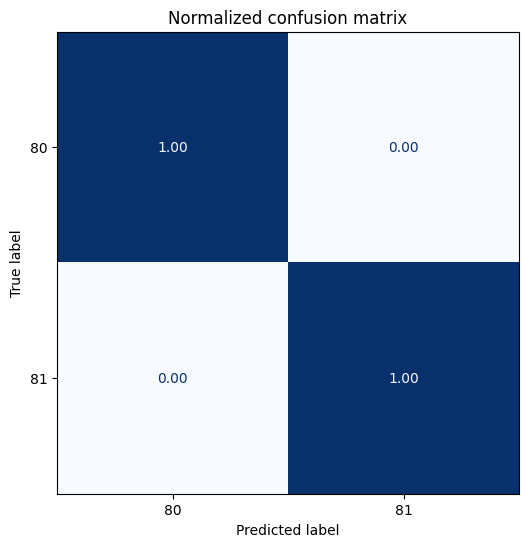

In [18]:
# confusion matrix of the classifier

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

# labels = emotions["train"].features["label"].names
labels = labels_df["label"]
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Model prediction

In [19]:
def model_predict(pred_text):
  pred_inputs = tokenizer(pred_text, return_tensors="pt")
  # print(pred_inputs)

  pred_inputs = {k:v.to(device) for k,v in pred_inputs.items()}
  with torch.no_grad():
    pred_hidden_state = model(**pred_inputs).last_hidden_state[:,0].cpu().numpy()

  return lr_clf.predict(pred_hidden_state), lr_clf.predict_proba(pred_hidden_state)

In [20]:
# predtext = "Is there a way to change my PIN without having to go to the bank?"
# predtext = "السلام عليكم"
predtext = "can i add my brother as new beneficiary?"
predtext = "عايز احول فلوس لاخويا"
pred = model_predict(predtext)

In [21]:
print(np.max(pred[1]))
print(getIntent(pred[0][0]))

0.9115068264927114
   label         intent
0     80  balance_check


In [22]:
intent = labels_df[labels_df.label == 80].intent.item()
print(intent)

balance_check


In [23]:
# Small Talk
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="joeddav/xlm-roberta-large-xnli")

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
sequence_to_classify = predtext

candidate_labels = ["greeting", "general inquiry", "identity check"]
pred = classifier(sequence_to_classify, candidate_labels)

best_score = np.max(pred["scores"])
idx = pred["scores"].index(np.max(pred["scores"]))
pred_label = pred["labels"][idx]
print("Intent: {}, score: {}".format(pred_label, best_score))

Intent: greeting, score: 0.8474510312080383


In [25]:
# Domain classification
from transformers import pipeline
from transformers import AutoModelForSequenceClassification

model_clfr = AutoModelForSequenceClassification.from_pretrained(model_ckpt, local_files_only=True)
pipe = pipeline("text-classification", model=model_clfr, tokenizer=tokenizer)

In [26]:
print(predtext)
pipepred = pipe(predtext)
print(pipepred)
print(pipepred[0]['label'])

عايز احول فلوس لاخويا
[{'label': 'topping_up_by_card', 'score': 0.585348904132843}]
topping_up_by_card


## Save the model on disk

In [27]:
import pickle
filename = 'Data/UDModel_banks.sav'
pickle.dump(lr_clf, open(filename, 'wb'))